## Negative examples analysis

In [ ]:
import json

with open("/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/preprocessed_law_dataset.json", "r") as f:
    data = json.load(f)
distinct_ids = set()
for d in data:
    distinct_ids.add((d["q_id"], d["cot_id"]))

num_total_examples = 0
num_negative_examples = 0
with open("/nfs/scratch/staff/leedo/Multi-GenPRM/prm_datasets/preprocessed_law_dataset.json", "r") as f:
    data = json.load(f)
for d in data:
    if not (d["q_id"], d["cot_id"]) in distinct_ids:
        distinct_ids.add((d["q_id"], d["cot_id"]))
        num_total_examples += 1
        if -1 in d["labels"]:
            num_negative_examples += 1
print(f"{num_negative_examples}/{num_total_examples}")

## Data coverage

In [ ]:
import json
from datasets import load_dataset

category = "engineering"
print(f"Loading dataset for category: {category}...")
dataset = load_dataset("UW-Madison-Lee-Lab/MMLU-Pro-CoT-Train-Labeled", split="train")
category_name = "computer science" if category == "computer_science" else category
dataset = [d for d in dataset if d["category"] == category_name]

distinct_ids = set()
for d in dataset:
    distinct_ids.add((d["id"], d["cot_id"]))
print(len(distinct_ids))

with open(f"/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/preprocessed_{category}_dataset.json", "r") as f:
    data = json.load(f)
distinct_ids = set()
for d in data:
    distinct_ids.add((d["question"], "\n\n".join(d["steps"])))
print(len(distinct_ids))

with open(f"/nfs/scratch/staff/leedo/VersaPRM/datasets/Qwen3-32B_datasets/preprocessed_thinkprm_{category}_dataset.json", "r") as f:
    data = json.load(f)
for d in data:
    distinct_ids.add((d["question"], "\n\n".join(d["steps"])))
print(len(distinct_ids))

with open(f"/nfs/scratch/staff/leedo/Multi-GenPRM/datasets_with_hint/preprocessed_{category}_dataset.json", "r") as f:
    data = json.load(f)
for d in data:
    distinct_ids.add((d["question"], "\n\n".join(d["steps"])))
print(len(distinct_ids))

## Cot length analysis

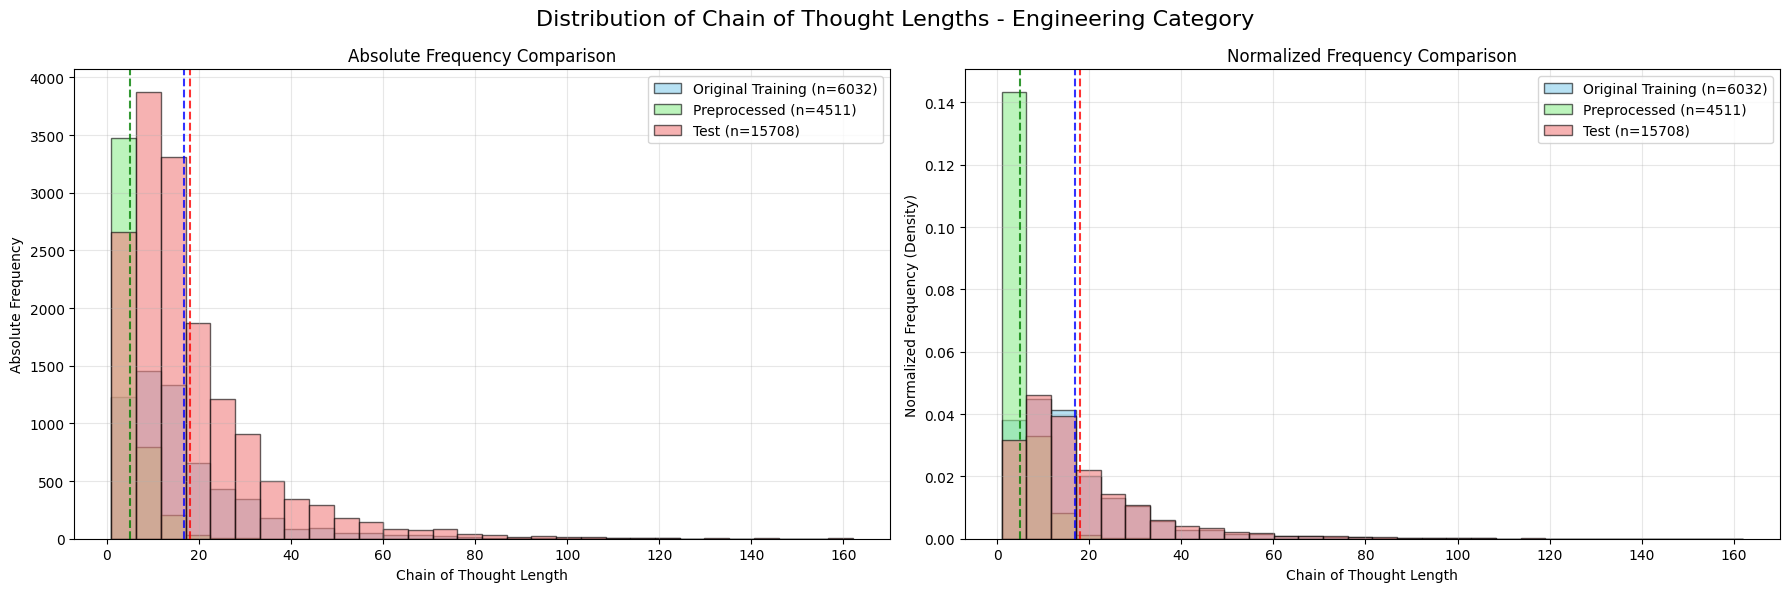

Summary statistics for engineering category:

Original Training Data:
  Total samples: 6032
  Mean CoT length: 16.84
  Median CoT length: 13.00
  Min CoT length: 2
  Max CoT length: 140
  Standard deviation: 14.32

Preprocessed Data:
  Total samples: 4511
  Mean CoT length: 5.06
  Median CoT length: 4.00
  Min CoT length: 1
  Max CoT length: 31
  Standard deviation: 3.36

Test Data:
  Total samples: 15708
  Mean CoT length: 18.08
  Median CoT length: 14.00
  Min CoT length: 2
  Max CoT length: 162
  Standard deviation: 15.21


In [13]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from datasets import load_dataset

category = "engineering"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/default"

# 1. Load original training data
train_dataset = load_dataset("UW-Madison-Lee-Lab/MMLU-Pro-CoT-Train-Labeled", split="train")
category_name = "computer science" if category == "computer_science" else category
train_dataset = [d for d in train_dataset if d["category"] == category_name]

train_cot_lengths = []
for d in train_dataset:
    cot = ast.literal_eval(d["chain_of_thoughts"])
    labels = ast.literal_eval(d["labels"])
    assert len(cot) == len(labels)
    train_cot_lengths.append(len(cot))

# 2. Load preprocessed data
with open(os.path.join(data_dir, f"preprocessed_{category}_dataset.json"), "r") as f:
    preprocessed_dataset = json.load(f)

preprocessed_cot_lengths = [len(d["steps"]) for d in preprocessed_dataset]

# 3. Load test data
test_dataset = load_dataset("UW-Madison-Lee-Lab/MMLU-Pro-CoT-Eval", split="test")
test_dataset = [d for d in test_dataset if d["category"] == category_name]

test_cot_lengths = []
for d in test_dataset:
    cot = ast.literal_eval(d["chain_of_thoughts"])
    test_cot_lengths.append(len(cot))

# Create consistent bins for all datasets
all_lengths = train_cot_lengths + preprocessed_cot_lengths + test_cot_lengths
min_length = min(all_lengths)
max_length = max(all_lengths)
bins = np.linspace(min_length, max_length, 31)  # 30 bins with consistent edges

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f'Distribution of Chain of Thought Lengths - {category.title()} Category', fontsize=16)

# Plot 1: Absolute frequencies
ax1.hist(train_cot_lengths, bins=bins, alpha=0.6, color='skyblue', label=f'Original Training (n={len(train_cot_lengths)})', edgecolor='black')
ax1.hist(preprocessed_cot_lengths, bins=bins, alpha=0.6, color='lightgreen', label=f'Preprocessed (n={len(preprocessed_cot_lengths)})', edgecolor='black')
ax1.hist(test_cot_lengths, bins=bins, alpha=0.6, color='lightcoral', label=f'Test (n={len(test_cot_lengths)})', edgecolor='black')
ax1.set_xlabel('Chain of Thought Length')
ax1.set_ylabel('Absolute Frequency')
ax1.set_title('Absolute Frequency Comparison')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add mean lines for absolute plot
mean_train = np.mean(train_cot_lengths)
mean_prep = np.mean(preprocessed_cot_lengths)
mean_test = np.mean(test_cot_lengths)
ax1.axvline(mean_train, color='blue', linestyle='--', alpha=0.8, label=f'Train Mean: {mean_train:.1f}')
ax1.axvline(mean_prep, color='green', linestyle='--', alpha=0.8, label=f'Prep Mean: {mean_prep:.1f}')
ax1.axvline(mean_test, color='red', linestyle='--', alpha=0.8, label=f'Test Mean: {mean_test:.1f}')

# Plot 2: Normalized frequencies (density)
ax2.hist(train_cot_lengths, bins=bins, alpha=0.6, color='skyblue', label=f'Original Training (n={len(train_cot_lengths)})', 
         edgecolor='black', density=True)
ax2.hist(preprocessed_cot_lengths, bins=bins, alpha=0.6, color='lightgreen', label=f'Preprocessed (n={len(preprocessed_cot_lengths)})', 
         edgecolor='black', density=True)
ax2.hist(test_cot_lengths, bins=bins, alpha=0.6, color='lightcoral', label=f'Test (n={len(test_cot_lengths)})', 
         edgecolor='black', density=True)
ax2.set_xlabel('Chain of Thought Length')
ax2.set_ylabel('Normalized Frequency (Density)')
ax2.set_title('Normalized Frequency Comparison')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add mean lines for normalized plot
ax2.axvline(mean_train, color='blue', linestyle='--', alpha=0.8, label=f'Train Mean: {mean_train:.1f}')
ax2.axvline(mean_prep, color='green', linestyle='--', alpha=0.8, label=f'Prep Mean: {mean_prep:.1f}')
ax2.axvline(mean_test, color='red', linestyle='--', alpha=0.8, label=f'Test Mean: {mean_test:.1f}')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary statistics for {category} category:")
print("\nOriginal Training Data:")
print(f"  Total samples: {len(train_cot_lengths)}")
print(f"  Mean CoT length: {mean_train:.2f}")
print(f"  Median CoT length: {np.median(train_cot_lengths):.2f}")
print(f"  Min CoT length: {min(train_cot_lengths)}")
print(f"  Max CoT length: {max(train_cot_lengths)}")
print(f"  Standard deviation: {np.std(train_cot_lengths):.2f}")

print("\nPreprocessed Data:")
print(f"  Total samples: {len(preprocessed_cot_lengths)}")
print(f"  Mean CoT length: {mean_prep:.2f}")
print(f"  Median CoT length: {np.median(preprocessed_cot_lengths):.2f}")
print(f"  Min CoT length: {min(preprocessed_cot_lengths)}")
print(f"  Max CoT length: {max(preprocessed_cot_lengths)}")
print(f"  Standard deviation: {np.std(preprocessed_cot_lengths):.2f}")

print("\nTest Data:")
print(f"  Total samples: {len(test_cot_lengths)}")
print(f"  Mean CoT length: {mean_test:.2f}")
print(f"  Median CoT length: {np.median(test_cot_lengths):.2f}")
print(f"  Min CoT length: {min(test_cot_lengths)}")
print(f"  Max CoT length: {max(test_cot_lengths)}")
print(f"  Standard deviation: {np.std(test_cot_lengths):.2f}")

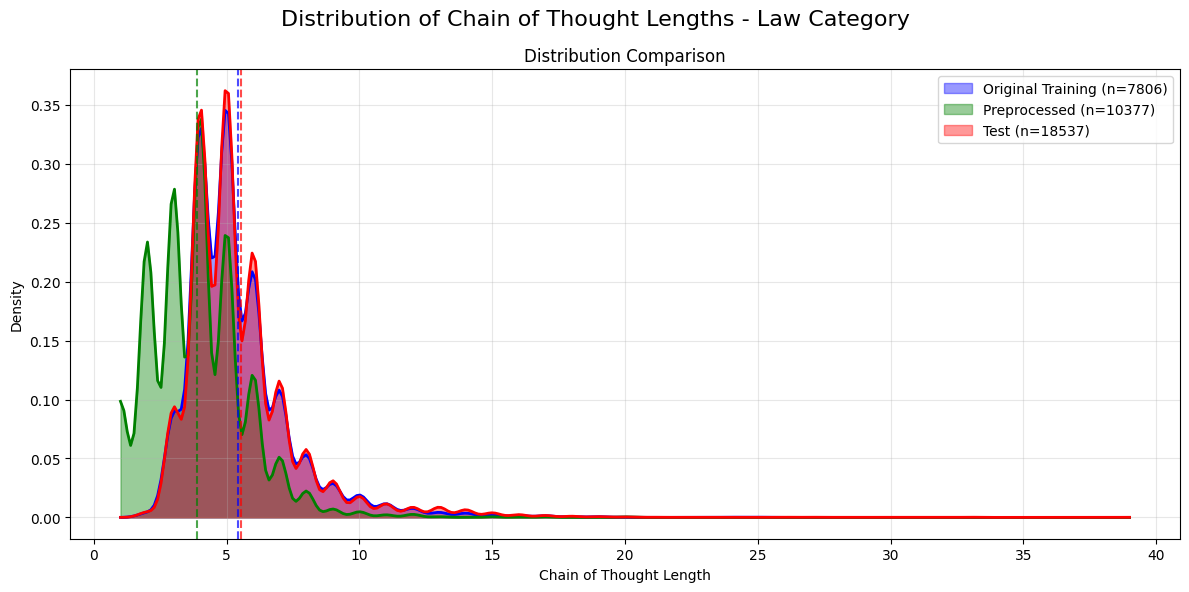

Summary statistics for law category:

Original Training Data:
  Total samples: 7806
  Mean CoT length: 5.44
  Median CoT length: 5.00
  Min CoT length: 2
  Max CoT length: 25
  Standard deviation: 1.99

Preprocessed Data:
  Total samples: 10377
  Mean CoT length: 3.87
  Median CoT length: 4.00
  Min CoT length: 1
  Max CoT length: 20
  Standard deviation: 1.80

Test Data:
  Total samples: 18537
  Mean CoT length: 5.52
  Median CoT length: 5.00
  Min CoT length: 2
  Max CoT length: 39
  Standard deviation: 2.20


In [21]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from datasets import load_dataset
from scipy import stats
from scipy.stats import gaussian_kde

category = "law"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/default"

# 1. Load original training data
train_dataset = load_dataset("UW-Madison-Lee-Lab/MMLU-Pro-CoT-Train-Labeled", split="train")
category_name = "computer science" if category == "computer_science" else category
train_dataset = [d for d in train_dataset if d["category"] == category_name]

train_cot_lengths = []
for d in train_dataset:
    cot = ast.literal_eval(d["chain_of_thoughts"])
    labels = ast.literal_eval(d["labels"])
    assert len(cot) == len(labels)
    train_cot_lengths.append(len(cot))

# 2. Load preprocessed data
with open(os.path.join(data_dir, f"preprocessed_{category}_dataset.json"), "r") as f:
    preprocessed_dataset = json.load(f)

preprocessed_cot_lengths = [len(d["steps"]) for d in preprocessed_dataset]

# 3. Load test data
test_dataset = load_dataset("UW-Madison-Lee-Lab/MMLU-Pro-CoT-Eval", split="test")
test_dataset = [d for d in test_dataset if d["category"] == category_name]

test_cot_lengths = []
for d in test_dataset:
    cot = ast.literal_eval(d["chain_of_thoughts"])
    test_cot_lengths.append(len(cot))

# Create x-axis range for smooth plotting
all_lengths = train_cot_lengths + preprocessed_cot_lengths + test_cot_lengths
x_min, x_max = min(all_lengths), max(all_lengths)
x = np.linspace(x_min, x_max, 300)

# Calculate kernel density estimates
kde_train = gaussian_kde(train_cot_lengths)
kde_prep = gaussian_kde(preprocessed_cot_lengths)
kde_test = gaussian_kde(test_cot_lengths)

# Create single plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle(f'Distribution of Chain of Thought Lengths - {category.title()} Category', fontsize=16)

# Filled density curves (area plot)
ax.fill_between(x, kde_train(x), alpha=0.4, color='blue', label=f'Original Training (n={len(train_cot_lengths)})')
ax.fill_between(x, kde_prep(x), alpha=0.4, color='green', label=f'Preprocessed (n={len(preprocessed_cot_lengths)})')
ax.fill_between(x, kde_test(x), alpha=0.4, color='red', label=f'Test (n={len(test_cot_lengths)})')

# Add line plots on top for clarity
ax.plot(x, kde_train(x), color='blue', linewidth=2)
ax.plot(x, kde_prep(x), color='green', linewidth=2)
ax.plot(x, kde_test(x), color='red', linewidth=2)

ax.set_xlabel('Chain of Thought Length')
ax.set_ylabel('Density')
ax.set_title('Distribution Comparison')
ax.grid(True, alpha=0.3)
ax.legend()

# Add mean lines
mean_train = np.mean(train_cot_lengths)
mean_prep = np.mean(preprocessed_cot_lengths)
mean_test = np.mean(test_cot_lengths)
ax.axvline(mean_train, color='blue', linestyle='--', alpha=0.7)
ax.axvline(mean_prep, color='green', linestyle='--', alpha=0.7)
ax.axvline(mean_test, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Summary statistics for {category} category:")
print("\nOriginal Training Data:")
print(f"  Total samples: {len(train_cot_lengths)}")
print(f"  Mean CoT length: {mean_train:.2f}")
print(f"  Median CoT length: {np.median(train_cot_lengths):.2f}")
print(f"  Min CoT length: {min(train_cot_lengths)}")
print(f"  Max CoT length: {max(train_cot_lengths)}")
print(f"  Standard deviation: {np.std(train_cot_lengths):.2f}")

print("\nPreprocessed Data:")
print(f"  Total samples: {len(preprocessed_cot_lengths)}")
print(f"  Mean CoT length: {mean_prep:.2f}")
print(f"  Median CoT length: {np.median(preprocessed_cot_lengths):.2f}")
print(f"  Min CoT length: {min(preprocessed_cot_lengths)}")
print(f"  Max CoT length: {max(preprocessed_cot_lengths)}")
print(f"  Standard deviation: {np.std(preprocessed_cot_lengths):.2f}")

print("\nTest Data:")
print(f"  Total samples: {len(test_cot_lengths)}")
print(f"  Mean CoT length: {mean_test:.2f}")
print(f"  Median CoT length: {np.median(test_cot_lengths):.2f}")
print(f"  Min CoT length: {min(test_cot_lengths)}")
print(f"  Max CoT length: {max(test_cot_lengths)}")
print(f"  Standard deviation: {np.std(test_cot_lengths):.2f}")

## Predicted Positive vs Negative

In [1]:
import json
import os
from tqdm import tqdm

category = "law"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/evaluation_results/all_14B_orm_style_v3/10x"
# "/nfs/scratch/staff/leedo/Multi-GenPRM/evaluation_results/all_14B_orm_style_v2/10x" # orm style prm (balanced)
# "/nfs/scratch/staff/leedo/Multi-GenPRM/evaluation_results/all_14B_orm_style_v2/10x" # orm style prm (balanced)


with open(os.path.join(data_dir, f"eval_{category}_dataset.json"), "r") as f:
    dataset = json.load(f)

positive, negative = 0, 0
for data in tqdm(dataset):
    for rewards in data["rewards"]:
        for r in rewards:
            if r > 0.5:
                positive += 1
            else:
                negative += 1
print(positive, negative)
# orm style prm (unbalanced training data): 60114 125256
# orm style prm (balanced training data): 60883 124487
# orm: 90283 95087

100%|██████████| 145/145 [00:00<00:00, 7715.99it/s]

50081 135289


## Training Critiques Length

In [ ]:
import json
import os
from tqdm import tqdm
from transformers import AutoTokenizer

category = "law"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/QwQ-32B"

with open(os.path.join(data_dir, f"preprocessed_{category}_dataset.json"), "r") as f:
    dataset = json.load(f)
    
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-7B")

length = []
for data in tqdm(dataset):
    critique = data["critique"]
    length.append(tokenizer.encode(critique))
    
print(sum(length)/len(length))
# prm: 60114 125256
# orm: 90283 95087

In [4]:
import re

def truncate_after_last_boxed_step(text):
    """
    Truncates the text after the last model-generated verdict line.
    Ignores any instructional examples (e.g., lines after '**Case').
    """
    lines = text.splitlines(keepends=True)

    verdict_pattern = re.compile(r'^Step\s+\d+:\s+The step is \\boxed{(?:correct|incorrect)}')
    case_pattern = re.compile(r'^\*\*Case')

    end_idx = -1
    for i, line in enumerate(lines):
        if case_pattern.match(line):
            break  # stop before instructional section
        if verdict_pattern.match(line):
            end_idx = i

    if end_idx == -1:
        return text  # no match found

    return ''.join(lines[:end_idx + 1])

test = """Step 1: The step is \\boxed{correct}\n
Step 2: The step is \\boxed{correct}\n
Step 3: The step is \\boxed{correct}\n
Step 4: The step is \\boxed{correct}\n

**Case 1 — All N steps are correct**:\n  
Step 1: The step is \\boxed{correct}\n
Step 2: The step is \\boxed{correct}\n
Step 3: The step is \\boxed{correct}\n
Step 4: The step is \\boxed{correct}"""

print(truncate_after_last_boxed_step(test))

Step 1: The step is \boxed{correct}

Step 2: The step is \boxed{correct}

Step 3: The step is \boxed{correct}

Step 4: The step is \boxed{correct}



## Training Data Positive / Negative

In [9]:
import json
import os
from tqdm import tqdm

category = "biology"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/datasets/train" # orm style prm (balanced)

with open(os.path.join(data_dir, f"{category}_dataset.json"), "r") as f:
    dataset = json.load(f)

positive, negative = 0, 0
for data in tqdm(dataset):
    if -1 in data["labels"]:
        negative += 1        
    else:
        positive += 1
print(positive, negative)
# orm style prm (unbalanced training data): 60114 125256
# orm style prm (balanced training data): 60883 124487
# orm: 90283 95087

100%|██████████| 6420/6420 [00:00<00:00, 2886422.09it/s]

3659 2761


## Prediction Distribution

In [ ]:
import json
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

category = "law"
data_dir = "/nfs/scratch/staff/leedo/Multi-GenPRM/evaluation_results/all_14B_orm_style_v3/10x" # orm style prm (balanced)

with open(os.path.join(data_dir, f"eval_{category}_dataset.json"), "r") as f:
    dataset = json.load(f)

rewards = []
for data in tqdm(dataset):
    for r in data["rewards"]:
        r = np.nanmean(r)
        rewards.append(r)
plt.hist(rewards)

# orm style prm (unbalanced training data): 60114 125256
# orm style prm (balanced training data): 60883 124487
# orm: 90283 95087